In [2]:
import seaborn as sns
from matplotlib.pyplot import figure, subplots_adjust, tight_layout, subplots, gca
import sys
from pandas import concat, melt, DataFrame
from matplotlib.offsetbox import AnchoredText
import os
from besca._helper import get_raw
import numpy as np
import scanpy as sc

In [3]:
sequential_colors = sns.color_palette("GnBu_d", 10)
sns.set(style="whitegrid") # palette="GnBu_d"
cmap = 'viridis'

# Define folder - notebook location
root_path = os.getcwd()
prevfolder = os.path.join(root_path, 'plots/') # Directory where plots will be saved
mplots = True # Set to True in order to export the plots

# Define the folder for plots 
sc.set_figure_params()
sc.settings.figdir = prevfolder

In [4]:
def stacked_violin(tidy_data,
                   x_axis,
                   y_axis,
                   subset_variable_label,
                   subset_variables,
                   fig_width = 8,
                   fig_height = 4,
                   order = None,
                   inner = 'box'):
    """ plot stacked violin plots.
    
    General plotting function to produce stacked violin plots.

    parameters
    ----------
    tidy_data: DataFrame
        pandas DataFrame containing the complete data that is to be plotted in a tidy format.
    x_axis: `str`
        string identifying which column of the DataFrame is to be plotted on the x-axis
    y_axis: `str`
        string identifying which column of the DataFrame is to be plotted on the y-axis
    subset_variable_label: `str`
        string identifiyng which column of the DataFrame contains the variables that 
        should be used to make datasubsets for each plot of the stacked violin plot
    subset_variabels: `list`
        list identifying the subsets that should be generated
    fig_width: `int` | default = 8
        int value defining figure width
    fig_height: `int` | default = 4
        int value defining figure height of one figure
    order:
    inner: 'box' or 'quartile' or 'point' or 'stick'
        define how the datapoints should be displayed in the violin interior, see seaborns documentation for more details

    returns
    -------
    Figure
        
    """
    
    #determine number of subplots
    number_of_subplots=len(subset_variables)
    
    #initiate figure
    fig = figure()
    
    #adjust size of figure if desired
    if fig_width is not None:
        fig.set_figwidth(fig_width)
    if fig_height is not None:
        fig.set_figheight(fig_height * number_of_subplots)
    
    #adjust amount of space between subplots
    subplots_adjust(hspace=0.000)
    
    #########################################################
    #plot first figure (this adds the legend above the plot)
    #########################################################
    
    #generate datasubset
    data = tidy_data[tidy_data.get(subset_variable_label) == subset_variables[0]];
    
    #plot figure
    ax0 = fig.add_subplot(number_of_subplots,1,1)
    ax0 = sns.violinplot(x=x_axis, y=y_axis,  data=data, palette="muted", order = order, inner = inner, legend = False)
    ax0.axes.get_xaxis().set_visible(False)
    ax0.yaxis.tick_right()

    
    #get correct label for the y-axis
    ax0.set_ylabel(subset_variables[0])

    #move legend above the plot
    #ax0.legend(loc=9, bbox_to_anchor=(0.5, 1.5), ncol=2)
    #if ax0.get_legend() is not None:
        #ax0.get_legend().remove()
        
        
    #########################################################
    #plot all subsequent figures dynamically
    #########################################################    
    if number_of_subplots >=2:
        
        for i in range(1, number_of_subplots):
            #subset data
            data = tidy_data[tidy_data.get(subset_variable_label) == subset_variables[i]]
            
            #get indicator for subplot number
            v = i+1
            
            #add subplot
            ax1 = fig.add_subplot(number_of_subplots,1,v, sharey = ax0)
            ax1 = sns.violinplot(x=x_axis, y=y_axis, data=data, palette="muted", order = order, inner = inner)
            ax1.axes.get_xaxis().set_visible(False)
            ax1.yaxis.tick_right()

            #get correct label for the y-axis
            ax1.set_ylabel(subset_variables[i])

            #remove legend since we only need it once
            #if ax1.get_legend() is not None:
                #ax1.get_legend().remove()

        #set x-axis on the last plot generated to visible
        ax1.axes.get_xaxis().set_visible(True)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    
    else:
        ax0.axes.get_xaxis().set_visible(True)
        ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90)

    tight_layout()
    subplots_adjust(hspace=0.000)
    return(fig)


In [8]:
def _make_tidy2(adata,
               genes,
               use_raw=True):
    """Helper function to generate the tidy dataframes necessary to plot gene expression.

    parameters
    ----------
    adata: `AnnData`
        AnnData object that contains the data you wish to plot
    genes: `[str]`
        list of strings identifiyng the genes which are to be plotted
    use_raw: `bool` | default = True
        boolian variable indicating if the gene expression values saved in adata.raw should be plotted or not 
    """

    #get raw object if using
    bdata = get_raw(adata) if use_raw else adata.copy()

    #convert X to array
    if type(bdata.X) == np.matrixlib.defmatrix.matrix:
       pass
    else:
       bdata.X = bdata.X.todense()

    #get index of raw gene names
    gene_index = bdata.var_names.tolist()

    #get index location of genes
    index = []
    for gene in genes:
        index.append(gene_index.index(gene))

    #extract AnnData object containing only the relevant genes (this decreases computational time later)
    bdata = bdata[:, index]
    matrix = bdata.X
    #check that the number of cells contained in the matrix is larger than 1
    if len(matrix) >= 1:
        condition = True
    else:
        condition = None
    
    #generate tidy frame 
    if condition:        
        #initialize an empty dataframe to save our results 
        gene_expression = DataFrame(index = range(matrix.shape[0]))
        if len(matrix.shape) > 1:
            #extract expression value for each of our genes
            #print('iterating through genes')
            for i in range(0, len(genes)):
                #get values 
                gene_expression[genes[i]] = matrix[:, i]
        else:
            #extract expression value for each of our genes
            #print('iterating through genes')
            for i in range(0, len(genes)):
                #get values 
                gene_expression[genes[i]] = matrix

        #make into tidy dataframe and add annotation
        gene_expression = melt(gene_expression, value_name='expression', var_name='gene')

    else:
        print('The dataset contains no cells for the required condition ')
    
    
    if condition is not None:
        data = gene_expression
        return(data)
    else:
        print('The dataset contains no cells for the required condition ')
    #return data and successfully exit function
    sys.exit(0)


In [9]:
def gene_expr_stacked(adata,
                      genes, 
                      subset_variable='celltype',
                      label_subset_variable=None,
                      use_raw=True,
                      fig_width=None,
                      fig_height=None,
                      order=None,
                      inner='stick'):
    
    """
    Stacked violin plot for visualization of genes expression.

    parameters
    ----------
    adata : :class:`~anndata.AnnData`
        The annotated data matrix used as input
    genes: `list`
        List of gene ids for which the gene expression levels should be compared
    subset_variable: `str`
        string identifying the column along which the AnnData object should be split into subsets. Can contain as many groups as you wish. 
        parameters
    use_raw: `bool` (default = True)
        boolian indicator if adata.raw data should be used as input for gene expression levels
    fig_width: `int` | default = 15
        width of the generated figure
    fig_height: `int` | default = 8
        height of the generated figure
    order: lists of strings
        Order to plot the categorical levels in
    inner: `str` (default = 'stick')
        see seaborn violin plot.

    returns
    -------
    fig

    """
    if label_subset_variable is not None:
        label_subset_variable = label_subset_variable
    else: 
        label_subset_variable = subset_variable

    #get tidy data
    
    #define subsets
    subsets = adata.obs.get(subset_variable).value_counts().index.tolist()

    data_to_merge = {}
    for subset in subsets:
        adata_subset = adata[adata.obs.get(subset_variable) == subset]

        data= _make_tidy2(adata=adata_subset, 
                         genes=genes,
                         use_raw=use_raw)
        data[label_subset_variable]=subset

        data_to_merge.update({subset:data})

    #merge all iterations into one dataframe
    print('merging a total of ', str(len(subsets)), ' datasubset')
    
    #print('merging datasubset 1')
    data_merged = data_to_merge.get(subsets[0])
    for iteration in subsets[1:]:
        #print('merging subset' + str(variables.index(iteration) + 1))
        data_merged = concat([data_merged, data_to_merge.get(iteration)], axis=0)

    fig = stacked_violin(tidy_data=data_merged,
                         x_axis=label_subset_variable,
                         y_axis='expression',
                         subset_variable_label='gene' ,
                         subset_variables=genes,
                         fig_width=fig_width,
                         fig_height=fig_height,
                         order=order,
                         inner=inner)
    return(fig)

In [6]:
ROSS_SERVER =  '' ## Roche server
url = ROSS_SERVER + '/scseq/Smillie2019_human_IBD/analyzed/standard_2_7_incl_batch/adata_celltype_annotation_extended.h5ad'
filename = 'Colon_healthy_inflamed.h5ad'

adata = sc.read(filename, backup_url=url)

cond1='Health' ### this is used to partition (e.g. days/treaments/categories)
cond3='Subject' ### this is used as replicates
cond2=condition='Cluster'
cond4= 'dblabel'
title="Colon_healthy_inflamed"

,CELL,Cluster,Health,Location,Subject,celltype_highlevel,nGene,nUMI,original_name,percent_mito,n_counts,n_genes,louvain,Type,dblabel
0,N7.EpiA.AAGCAAGAGTCAAC-Epi,Cycling TA,Non-inflamed,Epi,N7,Epi,1507,7428,N7.EpiA.AAGCAAGAGTCAAC,0.057351,7428.0,1507,9,Epithelial,proliferating transit amplifying cell
1,N7.EpiA.ACGAGGGAGCTGAT-Epi,Enterocyte Progenitors,Non-inflamed,Epi,N7,Epi,828,2877,N7.EpiA.ACGAGGGAGCTGAT,0.009037,2877.0,828,4,Epithelial,enterocyte progenitor
2,N7.EpiA.ACGTTTACTGGTAC-Epi,Immature Enterocytes 2,Non-inflamed,Epi,N7,Epi,2318,15332,N7.EpiA.ACGTTTACTGGTAC,0.133707,15332.0,2318,7,Epithelial,immature enterocyte
3,N7.EpiA.AGAGAATGGTCATG-Epi,Enterocyte Progenitors,Non-inflamed,Epi,N7,Epi,884,3498,N7.EpiA.AGAGAATGGTCATG,0.002001,3498.0,884,4,Epithelial,enterocyte progenitor
4,N7.EpiA.AGAGCGGAGTATGC-Epi,TA 1,Non-inflamed,Epi,N7,Epi,858,3261,N7.EpiA.AGAGCGGAGTATGC,0.003067,3261.0,858,4,Epithelial,transit amplifying cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149727,N110.LPB.TTTGCGCAGGGTTCCC-Imm,Macrophages,Inflamed,LP,N110,Imm,1172,3549,N110.LPB.TTTGCGCAGGGTTCCC,0.063398,3549.0,1172,6,Myeloid,macrophage
149728,N110.LPB.TTTGCGCCATGTCGAT-Imm,Plasma,Inflamed,LP,N110,Imm,1356,9534,N110.LPB.TTTGCGCCATGTCGAT,0.019194,9534.0,1356,0,B_cells,plasma cell
149729,N110.LPB.TTTGCGCTCAACGAAA-Imm,CD4+ Activated Fos-hi,Inflamed,LP,N110,Imm,858,2084,N110.LPB.TTTGCGCTCAACGAAA,0.051344,2084.0,858,1,T_cells,"activated CD4-positive, alpha-beta T cell"
149730,N110.LPB.TTTGCGCTCAACGGCC-Imm,Plasma,Inflamed,LP,N110,Imm,1753,12962,N110.LPB.TTTGCGCTCAACGGCC,0.019981,12962.0,1753,0,B_cells,plasma cell


merging a total of  3  datasubset



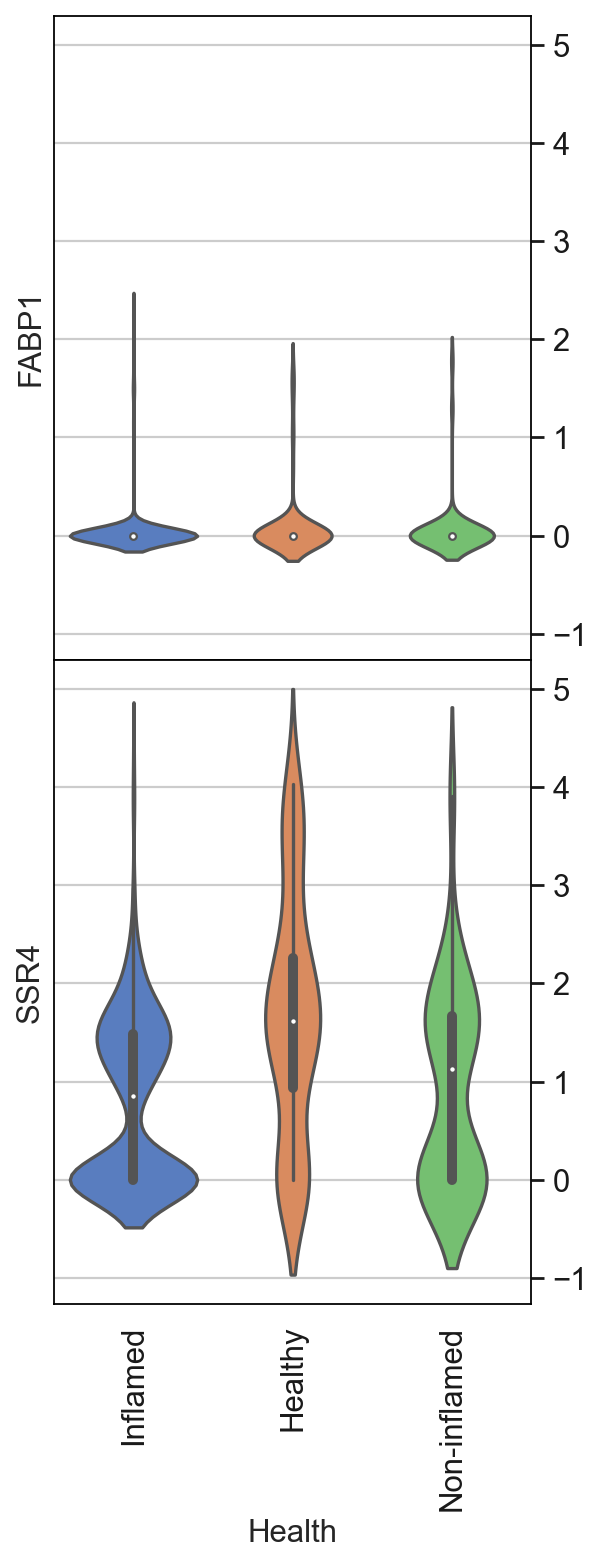

In [8]:
selected_cells = adata[adata.obs['Cluster'].isin(['GC'])].copy()
#selected_cells.obs
gene_expr_stacked(selected_cells,genes =['FABP1', 'SSR4'], subset_variable='Health', inner = 'box', fig_height= 5)
print()

merging a total of  3  datasubset



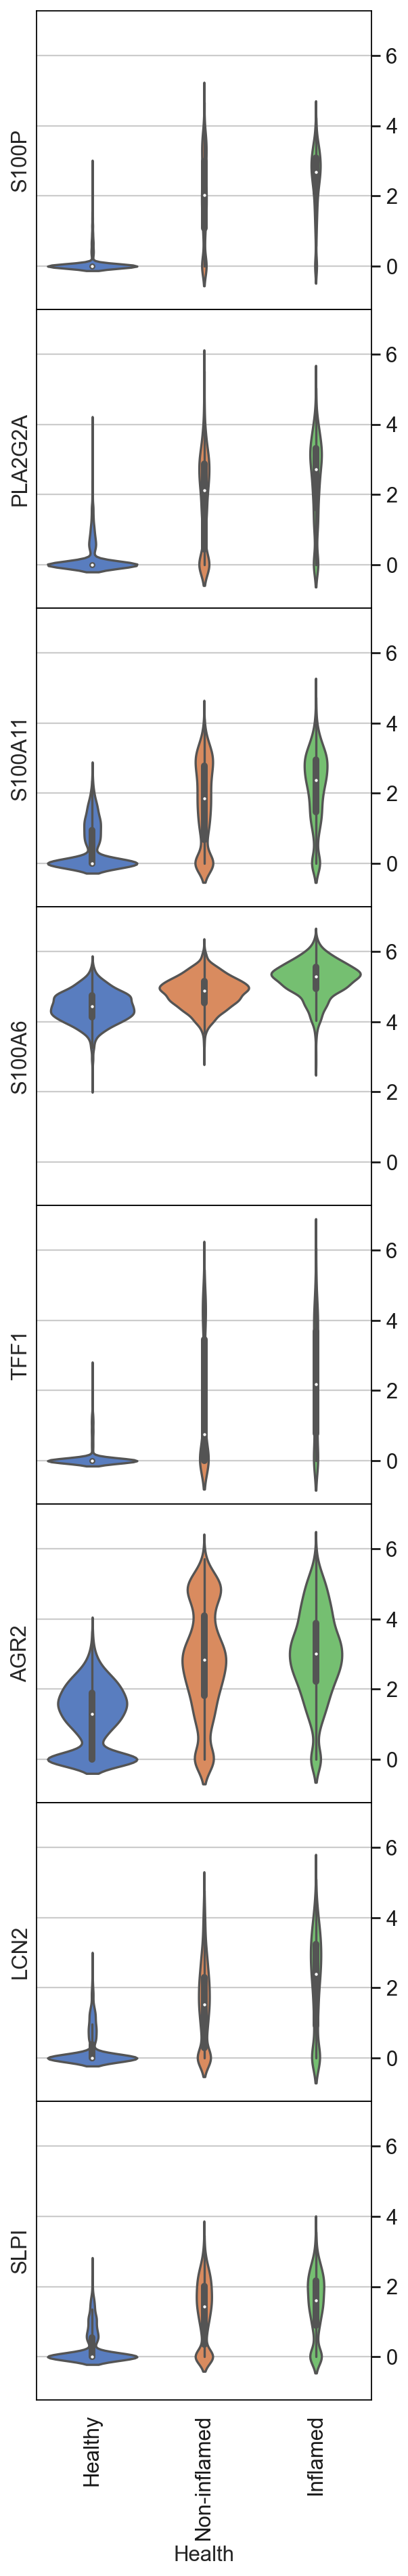

In [20]:
selected_cells = adata[adata.obs['Cluster'].isin(['Immature Enterocytes 2'])].copy()
#selected_cells.obs
gene_expr_stacked(selected_cells,genes =['S100P', 'PLA2G2A' ,'S100A11', 'S100A6', 'TFF1', 'AGR2', 'LCN2' ,'SLPI'], subset_variable='Health', inner = 'box', fig_height= 3, fig_width = 4)
print()

In [7]:
selected_cells = adata[adata.obs['dblabel'].isin(['transit amplifying cell'])].copy()
selected_cells = selected_cells[selected_cells.obs['Health'].isin(['Healthy', 'Inflamed'])].copy()
#selected_cells.obs
ax=gene_expr_stacked(selected_cells,genes =['PRAC1', 'S100P', 'MUC12'], subset_variable='Health', inner = 'box', fig_height= 3, fig_width = 5)
print()
fig = ax.get_figure()
fig.savefig('Transit_InfvsHe.png')

NameError: name '_make_tidy2' is not defined

merging a total of  3  datasubset



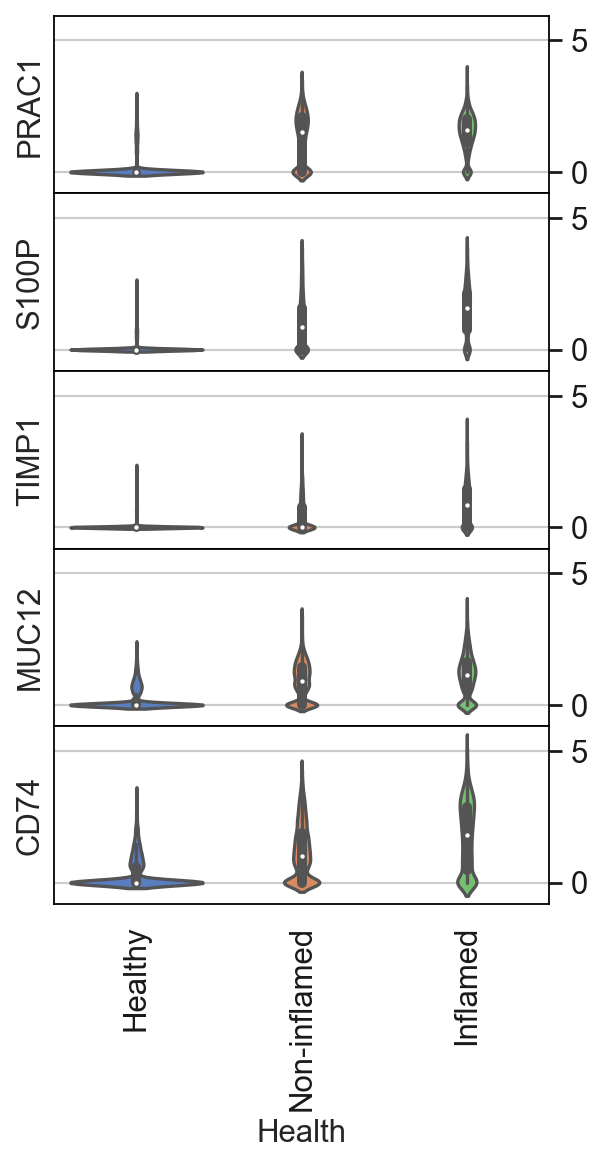

In [17]:
selected_cells = adata[adata.obs['dblabel'].isin(['transit amplifying cell'])].copy()
#selected_cells = selected_cells[selected_cells.obs['Health'].isin(['Healthy', 'Non-inflamed', 'Inflamed'])].copy()
#selected_cells.obs
ax=gene_expr_stacked(selected_cells,genes =['PRAC1', 'S100P', 'TIMP1', 'MUC12', 'CD74'], subset_variable='Health', inner = 'box', fig_height= 1.5, fig_width = 4, order = ['Healthy', 'Non-inflamed', 'Inflamed'])
print()
fig = ax.get_figure()
fig.savefig('transit amplifying cell.pdf')

merging a total of  3  datasubset



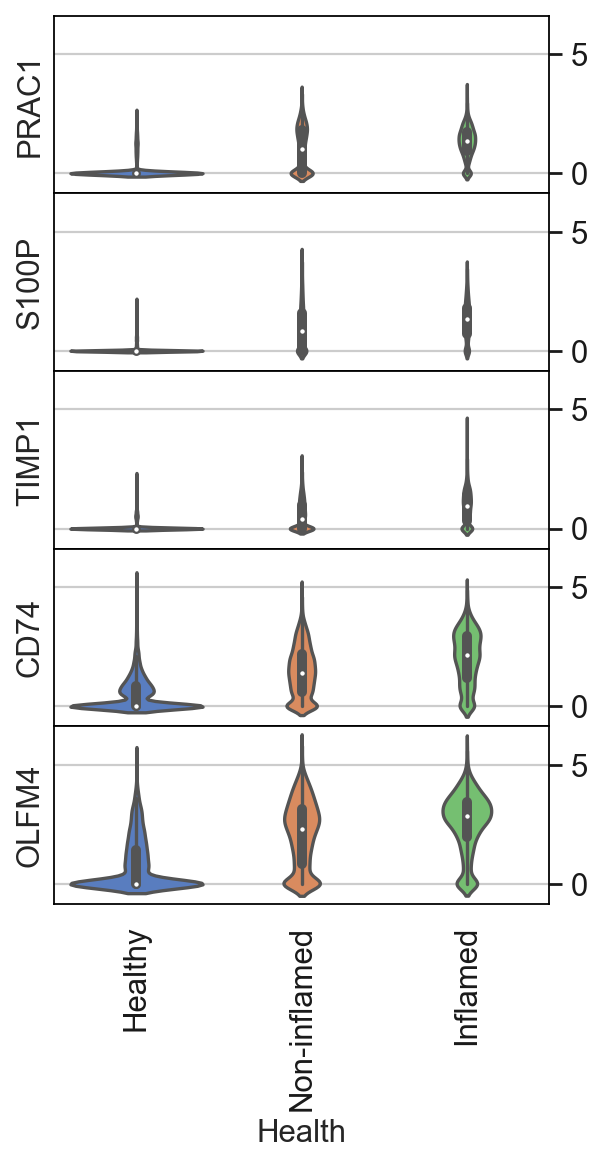

In [18]:
selected_cells = adata[adata.obs['dblabel'].isin(['proliferating transit amplifying cell'])].copy()
#selected_cells = selected_cells[selected_cells.obs['Health'].isin(['Healthy', 'Non-inflamed', 'Inflamed'])].copy()
#selected_cells.obs
ax=gene_expr_stacked(selected_cells,genes =['PRAC1', 'S100P', 'TIMP1', 'CD74', 'OLFM4'], subset_variable='Health', inner = 'box', fig_height= 1.5, fig_width = 4, order = ['Healthy', 'Non-inflamed', 'Inflamed'])
print()
fig = ax.get_figure()
fig.savefig('proliferating amplifying cell.pdf')

merging a total of  3  datasubset



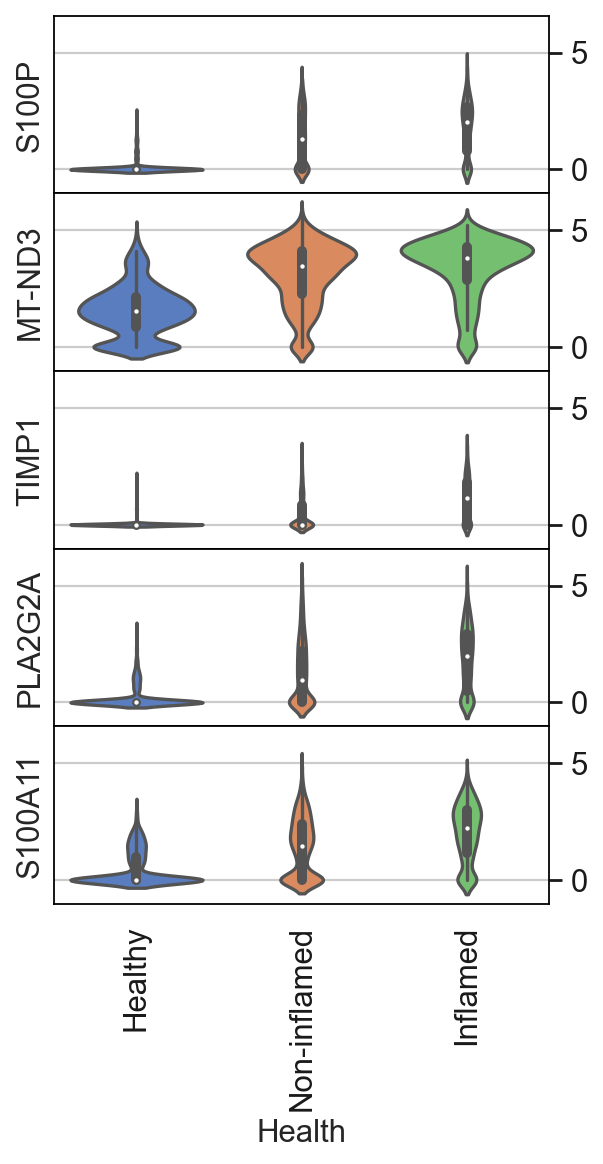

In [19]:
selected_cells = adata[adata.obs['dblabel'].isin(['enterocyte'])].copy()
#selected_cells = selected_cells[selected_cells.obs['Health'].isin(['Healthy', 'Non-inflamed', 'Inflamed'])].copy()
#selected_cells.obs
ax=gene_expr_stacked(selected_cells,genes =['S100P', 'MT-ND3', 'TIMP1', 'PLA2G2A', 'S100A11'], subset_variable='Health', inner = 'box', fig_height= 1.5, fig_width = 4, order = ['Healthy', 'Non-inflamed', 'Inflamed'])
print()
fig = ax.get_figure()
fig.savefig('enterocyte.pdf')

In [21]:
set(adata.obs['dblabel'])

{'CD141-positive myeloid dendritic cell',
 'CD1c-positive myeloid dendritic cell',
 'CD4-positive, alpha-beta memory T cell',
 'CD8-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta cytokine secreting effector T cell',
 'HEV endothelial cell',
 'activated CD4-positive, alpha-beta T cell',
 'brush cell',
 'endothelial cell',
 'enterocyte',
 'enterocyte progenitor',
 'enteroendocrine cell',
 'exhausted-like CD4-positive, alpha-beta T cell',
 'fibroblast',
 'follicular B cell',
 'germinal center B cell',
 'glial cell',
 'goblet cell',
 'immature enterocyte',
 'immature goblet cell',
 'inflammatory fibroblast',
 'inflammatory monocyte',
 'innate lymphoid cell',
 'macrophage',
 'mast cell',
 'microfold cell',
 'microvascular endothelial cell',
 'myofibroblast cell',
 'natural killer cell',
 'pericyte cell',
 'plasma cell',
 'proliferating B cell',
 'proliferating T cell',
 'proliferating monocyte',
 'proliferating transit amplifying cell',
 'regulatory T cell',
 'stem cell',
 'transi